In [4]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score, get_random_solution
from typing import Callable, Tuple
from abc import ABC, abstractmethod
from sortedcontainers import SortedList
import random
import numba

In [5]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [6]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [78]:
def greedy_2_regret_weighted(starting_solution: np.ndarray, distance_matrix: np.ndarray, costs: np.ndarray, weight_regret=0.5) -> list:
    cost_matrix = (distance_matrix + costs).T 
    n = len(distance_matrix)
    num_nodes_to_use = n // 2

    cycle = starting_solution.copy() 
    unvisited = np.ones(n, dtype=bool)
    unvisited[cycle] = 0 
  
    while len(cycle) < num_nodes_to_use:
        cycle_len = len(cycle)
        unvisited_indices = np.where(unvisited)[0]
        j_indices = np.arange(cycle_len)
        k_indices = (j_indices + 1) % cycle_len  
        cost_increases = (
            cost_matrix[cycle[j_indices], unvisited_indices[:, None]] +  
            cost_matrix[unvisited_indices[:, None], cycle[k_indices]] - 
            cost_matrix[cycle[j_indices], cycle[k_indices]]
        )
        best_increases = np.min(cost_increases, axis=1)  
        second_best_increases = np.partition(cost_increases, 1, axis=1)[:, 1] 
        
        weighted= best_increases - weight_regret*second_best_increases

        max_weighted_idx = np.argmin(weighted)
        i = unvisited_indices[max_weighted_idx]
        best_position = np.argmin(cost_increases[max_weighted_idx])
        cycle = np.insert(cycle, (best_position + 1) % cycle_len, i) 
        unvisited[i] = False  
    return cycle

In [8]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)
        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        n = 100
        
        indexes = self.indexes
        i_vals, j_vals = indexes[:, 0], indexes[:, 1]
        s=np.array(solution)
        i1 = s[(i_vals - 1) % n]
        i2 = s[i_vals]
        j1 = s[j_vals]
        j2 = s[(j_vals + 1) % n]
        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = 100
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        start = i - 1
        end = j + 2
        reversed_segment = set(range(start, end)) 
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in reversed_segment or y in reversed_segment:
                affected.add(k)

        return list(affected)

    
class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)

        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected_list: List[int], indexes=None):
        if indexes is None:
            indexes = np.arange(len(self.indexes)) 
        n = 100
        selected_indexes = self.indexes[indexes]
        indices_i, indices_j = selected_indexes[:, 0], selected_indexes[:, 1]
        i_prev = (indices_i - 1) % n
        i_next = (indices_i + 1) % n
        s=np.array(solution)
        u=np.array(unselected_list)
        node_prev = s[i_prev]
        node_current =s[indices_i]  
        node_next = s[i_next]
        node_unselected = u[indices_j]
        differences = (
            -self.dist_mat[node_prev, node_current]
            - self.dist_mat[node_current, node_next]
            + self.dist_mat[node_prev, node_unselected]
            + self.dist_mat[node_unselected, node_next]
        )
        return differences
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        n = len(solution)
        adjacent_indices = { (i - 1) % n, (i + 1) % n, i }
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in adjacent_indices or y in adjacent_indices:
                affected.add(k)
            if y == j:
                affected.add(k)
        
        return list(affected)

class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
     
        self.offsets = np.cumsum([0] + [n.neighborhood_size() for n in neighborhoods])
        self.size = self.offsets[-1]
        self.indexes = np.concatenate(
            [n.indexes for  n in neighborhoods]
        )
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        if indexes is None:
            differences = []
            for neighborhood in self.neighborhoods:
                differences.append(neighborhood.batch_get_differences(solution, unselected))
            return np.concatenate(differences)
        else:
            differences = []
            idx=0
            
            id1=0
            for neighborhood in self.neighborhoods:
                idx+=neighborhood.size
                idxs=np.array(indexes)
                idxs=idxs[idxs>id1]
                idxs=idxs[idxs<idx] 
                idxs=idxs-id1
                differences.append(neighborhood.batch_get_differences(solution, unselected, idxs))
                id1+=idx
            return np.concatenate(differences)
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
            size=self.neighborhoods[0].neighborhood_size()
            if ind < size:
                return self.neighborhoods[0].get_affected_indexes(ind, solution)
            else:
                ind-=size
                return [x+size for x in self.neighborhoods[1].get_affected_indexes(ind, solution)]
            

In [9]:
def steepest(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)

    solution = starting_solution.copy()

    while True:
        objective_changes = neighborhood.batch_get_differences(solution, unselected)
        best_index = np.argmin(objective_changes)
    
        if objective_changes[best_index] >= 0:
            return solution
    
        solution = neighborhood.modify_solution(best_index, solution, unselected)


In [109]:
def destroy(x: np.ndarray, n) -> np.ndarray:
    y = x.copy()
    ind1 = random.randint(0, n)
    ind2 = (ind1 + n // 4) % n
    if ind1 < ind2:
        y = np.concat((x[:ind1],x[ind2:]))
    else:
        y = x[ind2:ind1]
    return y 
    

def lns(distance_matrix, costs, neighborhood, if_ls=False):
    best_fit=999999999
    best_sol=None
    start_time=time.time()
    i=0
    x=get_random_solution(200)
    x=np.array(x)
    if if_ls:
        x = steepest(x, None, costs, neighborhood)
    previous_score=score(x, distance_matrix, costs)
    while time.time()-start_time<1:
        y=x.copy()
        y = destroy(y, 100)
        y = greedy_2_regret_weighted(y, distance_matrix, costs)
        if if_ls:
            y=steepest(y, dist, costs, neighborhood)
      
        scor=score(y, distance_matrix, costs)
        if scor<previous_score:
            x=y
        i+=1
        if  scor< best_fit:
            best_fit=scor
            best_sol=y
    return best_sol, i

In [63]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])


In [127]:
def test_method(Neighborhood: CombinedNeighborhood, dists, cost, coordinate,name='', if_ls=False):
    scores_2=[]
    sols_2=[]
    times = list()
    i1=[]
    for x in range(20):
        begin_time = time.time()
        solution_2, i=lns(dists, cost, Neighborhood, if_ls)
        i1.append(i)
        times.append(time.time() - begin_time)

        solution_2 = [int(e) for e in solution_2]
        sols_2.append(solution_2)
        scores_2.append(score(solution_2, dists, cost))   
    print('scores: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
    print(sols_2[scores_2.index(min(scores_2))])
    print(f'execution time: {min(times)} {sum(times)/len(times)} {max(times)}')
    if len(i1)>0:
        print(f'ils iterations: ', min(i1), sum(i1)/len(i1), max(i1))
    plot_solution(sols_2[scores_2.index(min(scores_2))], coordinate, cost, f'best solution for {name}')

In [115]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])

scores:  69532 69891.6 70463
[53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 65, 116, 43, 42, 184, 35, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 146, 22, 18, 108, 69, 159, 193, 41, 115, 139, 46, 68, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 148, 9, 62, 102, 144, 14, 49, 178, 106, 52, 55, 185, 165, 40, 90, 81, 196, 179, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 82, 92, 57, 129, 2, 75, 101, 1, 152, 97, 26, 100, 86]
execution time: 1.0009071826934814 1.0045138239860534 1.007915735244751
ils iterations:  108 133.0 143


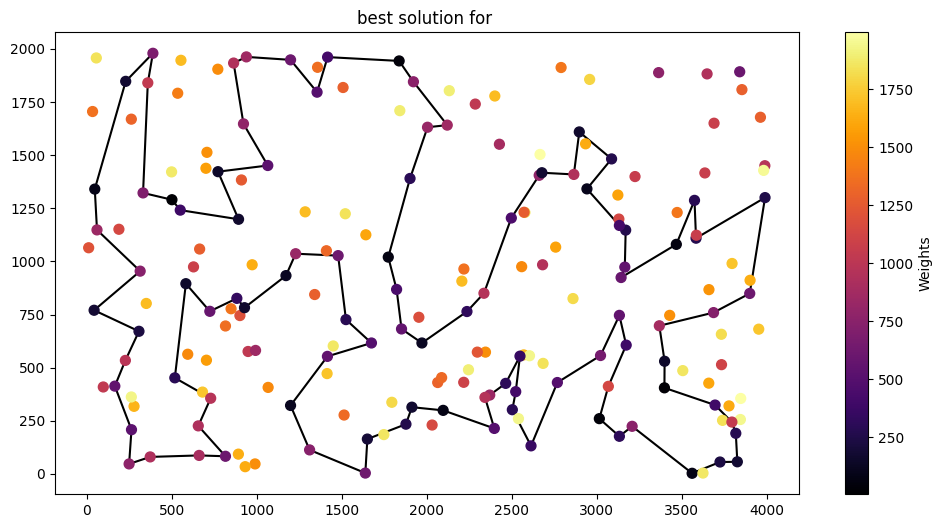

In [ ]:
test_method(neighborhood, dist, costs, coordinates)
test_method(neighborhood, dist, costs, coordinates, True)

In [124]:
n = 200
interNeighborhoodb = InterNeighborhood(distb, costsb, n // 2)
edgeNeighborhoodb = EdgeNeighborhood(distb, costsb, n // 2)
neighborhoodb = CombinedNeighborhood([edgeNeighborhoodb, interNeighborhoodb])

scores:  44272 44862.4 46097
[148, 47, 94, 66, 179, 166, 194, 176, 113, 103, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 21, 82, 8, 104, 144, 111, 0, 35, 109, 29, 160, 33, 11, 139, 138, 182, 25, 177, 5, 78, 175, 162, 80, 190, 136, 73, 31, 54, 193, 117, 198, 156, 1, 16, 27, 38, 63, 135, 122, 131, 121, 51, 90, 147, 6, 188, 169, 132, 13, 168, 195, 145, 15, 70, 3, 155, 184, 152, 170, 34, 55, 18, 62, 124, 106, 128, 86, 185, 99, 130, 95, 183, 140, 4, 149, 28, 59, 20, 60]
execution time: 1.0009098052978516 1.0048643589019775 1.0089268684387207
ils iterations:  110 129.8 135


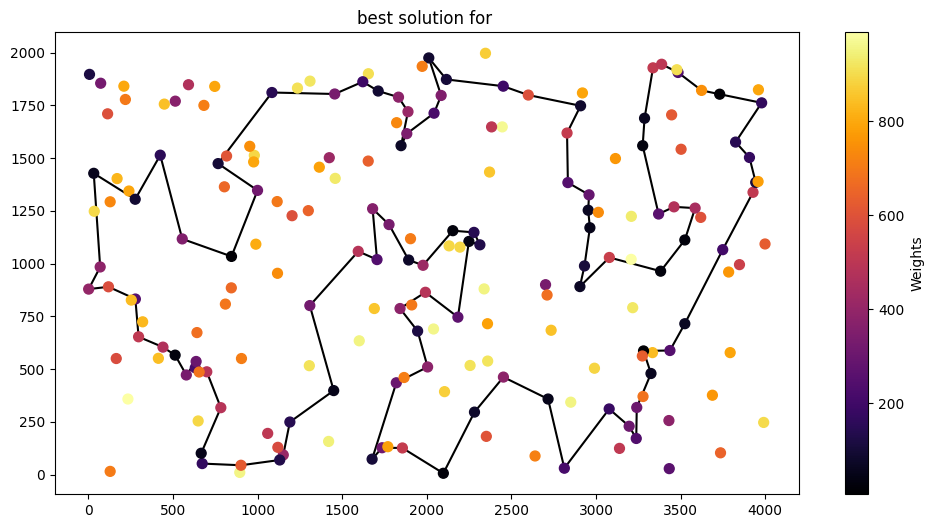

In [ ]:
test_method(neighborhoodb, distb, costsb, coordinatesb)
test_method(neighborhoodb, distb, costsb, coordinatesb, True)